In [1]:
# This notebooks implements a realNVP model for variational inference.
# The target distribution is the Neal's funnel (double well) distribution.

In [21]:
# autorelad when changes are made
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# add parent directory to path for imports
import sys, os
sys.path.append(os.path.abspath('..'))

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import time

from nflows.builders import build_realnvp
from nflows.distributions import StandardNormal, DiagNormal


In [55]:
# Initialize PRNG key
key = jax.random.PRNGKey(0)

In [56]:
# create a RealNVP flow
dim_input = 10
num_layers = 8
hidden_sizes = [512, 512]

flow, params = build_realnvp(
    key=key,
    dim=dim_input,
    num_layers=num_layers,
    hidden_sizes=hidden_sizes,
    max_log_scale = 3.0,
    use_permutation = False,
    use_linear = True,
    trainable_base=True,  # let the base adapt a bit
    loft_tau=50.
)


In [57]:
# sample from the flow
n_samples = 10_000
x_samples = flow.sample(params, key, shape=(n_samples,))

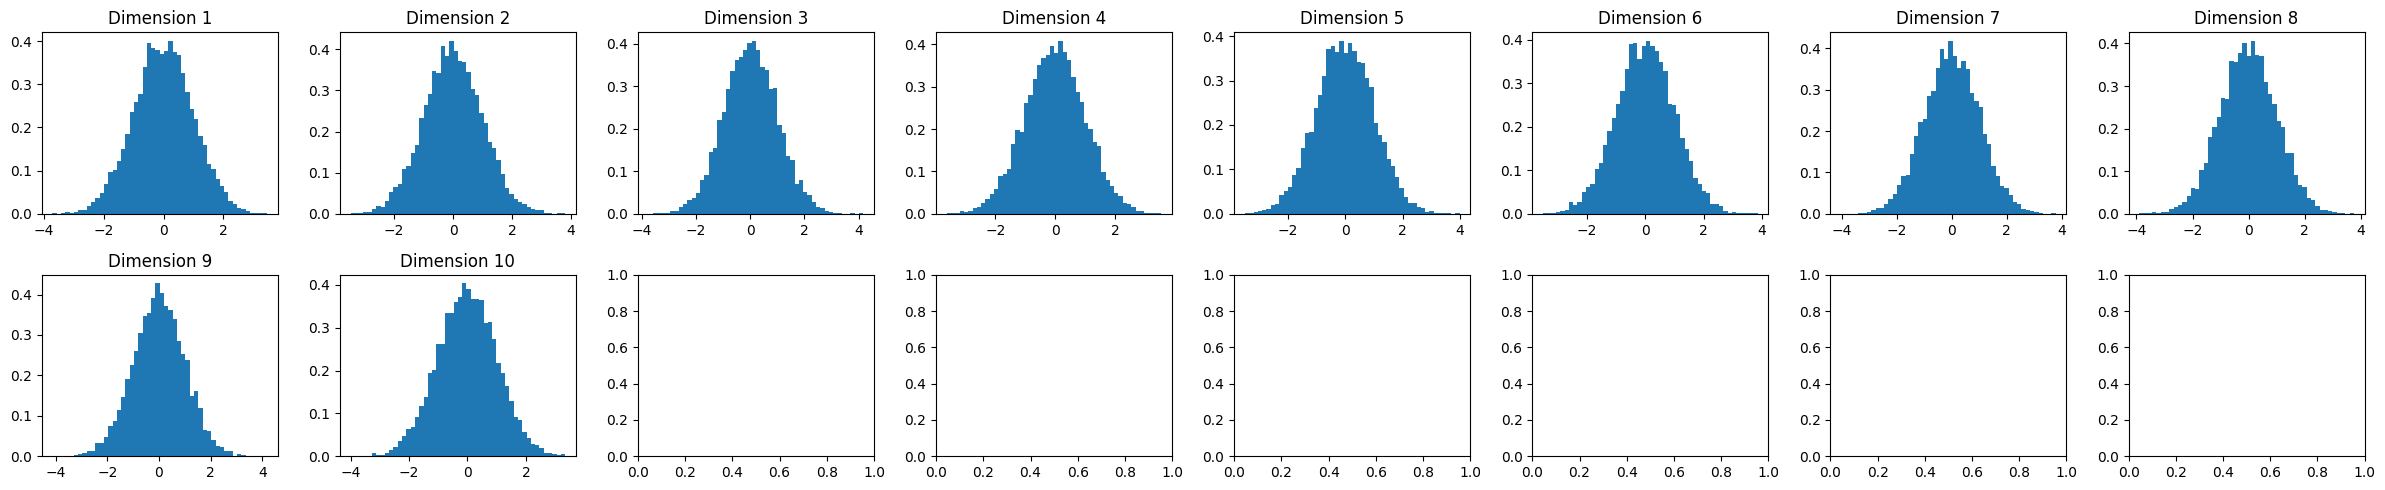

In [58]:
# for each dimension, plot histogram of samples
# make sure that at initialization, the samples look like standard normal
# this is because the flow is initialized to be close to identity for stable training
ncol = 8
nrow = dim_input // ncol + int(dim_input % ncol > 0)
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*2.5))
for i in range(dim_input):
    ax = axes[i // ncol, i % ncol]
    ax.hist(x_samples[:, i], bins=50, density=True)
    ax.set_title(f"Dimension {i+1}")
plt.tight_layout()

In [59]:
def log_target(x):
    """Neal's funnel in dimension D:
    sigma_0 = 3.0
    x_0 ~ N(0, sigma_0^2)
    x_i ~ N(0, exp(x_0/2)^2) for i=1,...,D-1
    
    Note: This is the log of the normalized target distribution so log_Z = 0.
    """
    D = x.shape[1]
    sigma_0 = 3.0
    x0 = x[:, 0]
    xi = x[:, 1:]
    
    log_p_x0 = -0.5 * ((x0 / sigma_0) ** 2) - jnp.log(sigma_0) - 0.5 * jnp.log(2 * jnp.pi)
    sigma_i = jnp.exp(0.5 * x0)
    log_p_xi = -0.5 * jnp.sum((xi / sigma_i[:, None]) ** 2, axis=1) - (D - 1) * (jnp.log(sigma_i) + 0.5 * jnp.log(2 * jnp.pi))
    return log_p_x0 + log_p_xi

def sample_neals_funnel(
        key,        # PRNG key
        n_samples,  # number of samples
        dim         # dimension of samples
    ):
    """Sample from Neal's funnel distribution."""
    sigma_0 = 3.0
    key_x0, key_xi = jr.split(key)
    x0 = jr.normal(key_x0, shape=(n_samples,)) * sigma_0
    sigma_i = jnp.exp(0.5 * x0)
    xi = jr.normal(key_xi, shape=(n_samples, dim - 1)) * sigma_i[:, None]
    return jnp.column_stack((x0, xi))


(-10.0, 10.0)

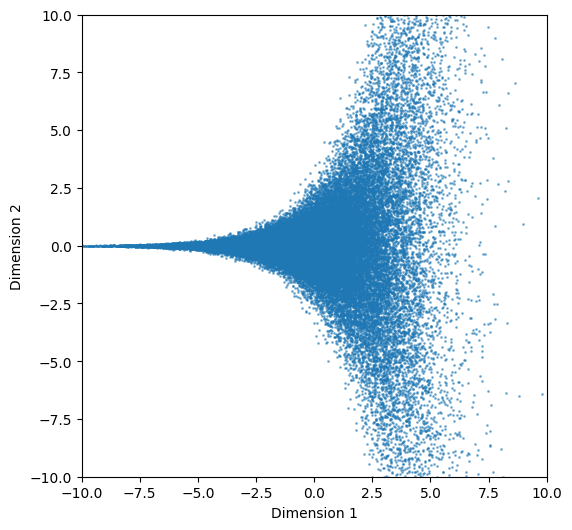

In [60]:
# sample from Neal's funnel
n_samples_target = 50_000
x_target_samples = sample_neals_funnel(key, n_samples_target, dim_input)

# scatter plot of first two dimensions
plt.figure(figsize=(6,6))
plt.scatter(x_target_samples[:, 0], x_target_samples[:, 1], alpha=0.5, s=1)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [61]:
log_Z_normalization_true = 0.
print(f"Estimated log normalization constant: {log_Z_normalization_true:.4f}")

Estimated log normalization constant: 0.0000


In [62]:
def reverse_kl_loss(params, key, n_samples, sticking_the_landing=True) -> jnp.ndarray:
    """
    Monte Carlo estimate of KL(q || π) up to an additive constant:

      L(params) = E_{x ~ q_params}[log q_params(x) - log π̃(x)]

    where log π̃ is the unnormalized log density.
    """
    params_stop_grad = jax.tree_util.tree_map(jax.lax.stop_gradient, params)
    key_sample, _ = jax.random.split(key)
    
    # ** Sticking the landing: **
    # allows to (sometimes/slightly) reduce the noise of the gradient estimator near convergence
    #
    # reference:
    # ==========
    # "Sticking the Landing: Simple, Lower-Variance Gradient Estimators for Variational Inference"
    # by Roeder, Wu, and Duvenaud, NeurIPS 2017
    if sticking_the_landing:
      x = flow.sample(params, key_sample, shape=(n_samples,))    
      log_q = flow.log_prob(params_stop_grad, x)
    else:
      # standard score function estimator
      x, log_q = flow.sample_and_log_prob(params, key_sample, shape=(n_samples,))    
    
    # compute log unnormalized target
    log_pi_tilde = log_target(x)
    
    # compute the ELBO
    elbo = jnp.mean(log_pi_tilde - log_q)
    
    # the loss is negative ELBO
    return - elbo

In [ ]:
# for stability, use gradient clipping
learning_rate = 1e-3
clip_norm = 5.0

optimizer = optax.chain(
    optax.clip_by_global_norm(clip_norm),
    optax.adam(learning_rate),
)

opt_state = optimizer.init(params)


In [64]:
def train_step(params, opt_state, key, n_samples):
    """
    basic training step:
    1. compute loss and gradients
    2. update parameters using optimizer
    3. return updated parameters and optimizer state
    """
    loss, grads = jax.value_and_grad(reverse_kl_loss)(params, key, n_samples)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# JIT compile the train step with n_samples as static argument because it affects the shape of arrays
train_step = jax.jit(train_step, static_argnames=("n_samples",))

In [65]:
params_train = params.copy()
key, key_train = jr.split(key)

In [66]:
# number of train iterations
niters = 10_000

# number of monte carlo samples per gradient estimate
n_samples = 10_000

loss_history = []


# do one step to trigger JIT compilation before timing
if True:
    key_train, key_step = jax.random.split(key_train)
    params_train, opt_state, loss = train_step(params_train, opt_state, key_step, n_samples)

time_start = time.time()
for step in range(niters):
    key_train, key_step = jax.random.split(key_train)
    params_train, opt_state, loss = train_step(params_train, opt_state, key_step, n_samples)
    loss_history.append(float(loss))

    if step % (niters // 20) == 0:
        time_since_start = time.time() - time_start
        time_per_iter = time_since_start / (step + 1)
        print(f"[{step:4d}/{niters}]: reverse-KL loss ≈ {float(loss):.4f}, time: {time_since_start:.1f}s, per 1k iter: {time_per_iter*1000:.4f}s")

[   0/10000]: reverse-KL loss ≈ 3.4682, time: 0.0s, per 1k iter: 24.4210s
[ 500/10000]: reverse-KL loss ≈ 0.2040, time: 8.0s, per 1k iter: 15.9204s
[1000/10000]: reverse-KL loss ≈ 0.1136, time: 16.1s, per 1k iter: 16.0358s
[1500/10000]: reverse-KL loss ≈ 0.0745, time: 24.2s, per 1k iter: 16.0900s
[2000/10000]: reverse-KL loss ≈ 0.0446, time: 32.3s, per 1k iter: 16.1349s
[2500/10000]: reverse-KL loss ≈ 0.0298, time: 40.4s, per 1k iter: 16.1539s
[3000/10000]: reverse-KL loss ≈ 0.0316, time: 48.5s, per 1k iter: 16.1606s
[3500/10000]: reverse-KL loss ≈ 0.0285, time: 56.6s, per 1k iter: 16.1695s
[4000/10000]: reverse-KL loss ≈ 0.0277, time: 64.7s, per 1k iter: 16.1764s
[4500/10000]: reverse-KL loss ≈ 0.0264, time: 72.8s, per 1k iter: 16.1774s
[5000/10000]: reverse-KL loss ≈ 0.0209, time: 80.9s, per 1k iter: 16.1850s
[5500/10000]: reverse-KL loss ≈ 0.0225, time: 89.1s, per 1k iter: 16.1895s
[6000/10000]: reverse-KL loss ≈ 0.0202, time: 97.2s, per 1k iter: 16.1910s
[6500/10000]: reverse-KL lo

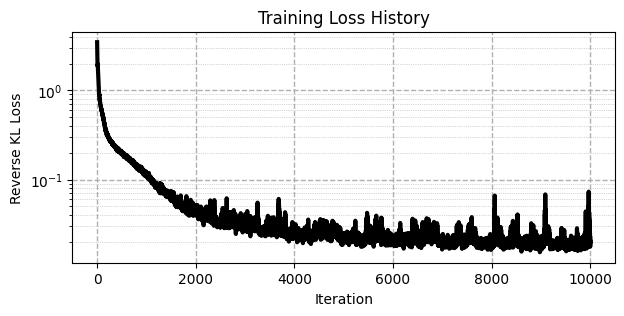

In [67]:
loss_history = np.array(loss_history)
negative_elbo = loss_history - log_Z_normalization_true


plt.figure(figsize=(7,3))
plt.plot(negative_elbo, c='black', lw=3)
# y on log scale
plt.yscale("log")

# add grid
plt.grid(which='major', linestyle='--', linewidth=1)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Reverse KL Loss")
plt.show()

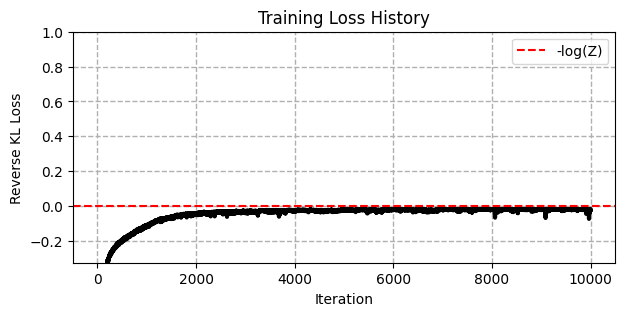

In [68]:
loss_history = np.array(loss_history)
elbo = -loss_history

plt.figure(figsize=(7,3))
plt.plot(elbo, c='black', lw=3)
# plot horizontal line at the true ELBO value (negative log normalization constant)
plt.axhline(y=-log_Z_normalization_true, color='red', linestyle='--', label='-log(Z)')
plt.legend()

# compute bottom 5% quantile of loss to set y-axis limit
bottom_5_percentile = np.percentile(elbo, 2)
plt.ylim(bottom_5_percentile, -log_Z_normalization_true + 1.0)

# add grid
plt.grid(which='major', linestyle='--', linewidth=1)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

plt.title("Training Loss History")
plt.xlabel("Iteration")
plt.ylabel("Reverse KL Loss")
plt.show()

In [69]:
# define a sampling function & jit compile it
def sample_flow(params, key, n_samples):
    return flow.sample(params, key, shape=(n_samples,))
sample_flow = jax.jit(sample_flow, static_argnames=("n_samples",))

In [70]:
# generate many samples from trained flow
n_samples = 10000
key, key_samples = jax.random.split(key)
# x_samples = flow.sample(params_train, key_samples, shape=(n_samples,))
x_samples = sample_flow(params_train, key_samples, n_samples)

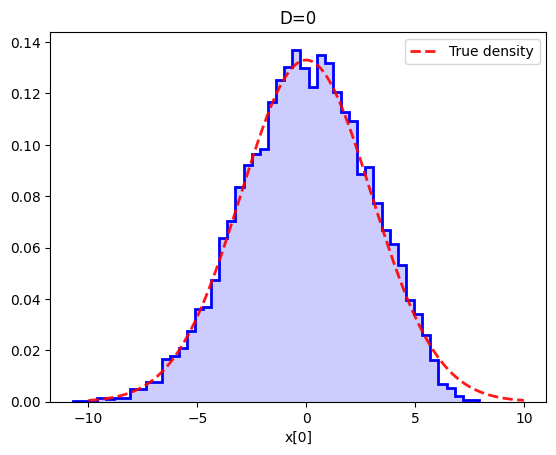

In [71]:
d = 0
plt.hist(x_samples[:, d], bins=50, density=True, histtype="step", linewidth=2, color='blue')
# fill with light color
plt.hist(x_samples[:, d], bins=50, density=True, histtype="stepfilled", alpha=0.2, color='blue')
plt.title(f"D={d}")
plt.xlabel(f"x[{d}]")
    

# superpose the true density: N(0, 3^2)
xarr = jnp.linspace(-10, 10, 1000)
import scipy.stats as stats
proba = stats.norm.pdf(xarr, loc=0.0, scale=3.0)
plt.plot(xarr, proba, 'r--', lw=2, label='True density', alpha=0.9)
plt.legend()

Text(0.5, 1.0, 'Ground Truth Samples')

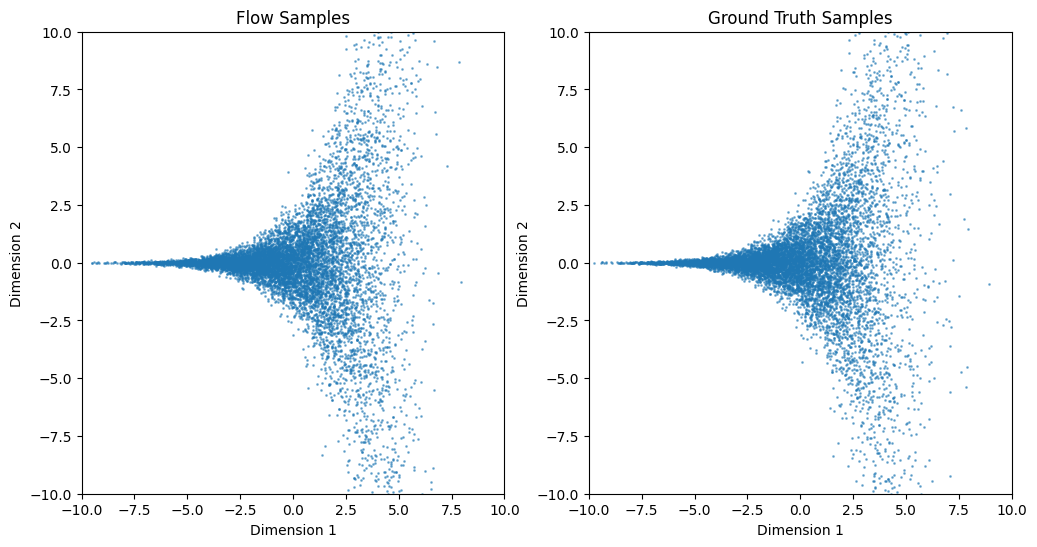

In [72]:
# scatter plot of first two dimensions
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.5, s=1)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title("Flow Samples")

plt.subplot(1,2,2)
# sample from Neal's funnel
n_samples_target = 10_000
x_target_samples = sample_neals_funnel(key, n_samples_target, dim_input)

# scatter plot of first two dimensions
plt.scatter(x_target_samples[:, 0], x_target_samples[:, 1], alpha=0.5, s=1)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title("Ground Truth Samples")